## Malignant Comments

Dataset Source: https://www.kaggle.com/datasets/surekharamireddy/malignant-comment-classification

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, set_seed, DataCollatorWithPadding

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.7 
         NumPy: 1.23.3
        Pandas: 1.4.4
      Datasets: 2.8.0
  Transformers: 4.28.1
         Torch: 2.0.0
      Evaluate: 0.2.2


#### Load & Start Preprocessing Dataset

In [3]:
parent_dir = "/Users/leedunn/Desktop/Projects_to_Train/Malignant Text/data"

data_file_location = os.path.join(parent_dir, "train.csv")

data = pd.read_csv(data_file_location)

data = data.rename(columns={"comment_text": "text"})

data = data.drop(columns=['id', "malignant", "highly_malignant", "rude", "loathe"])

data['text'] = data['text'].apply(lambda x: x.strip())
data['text'] = data['text'].replace(r'\n', " ", regex=True)

data['label'] = data['abuse'] + data['threat']

data['label'] = data['label'].apply(lambda x: 1 if x > 0 else 0)

data = data.drop(columns=['threat', 'abuse'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   label   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


#### Define Dictionaries to Convert Between String & Integer Class Values

In [4]:
labels = ['clean', 'malignant']

id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

NUM_OF_LABELS = len(labels)

print(labels)
print(NUM_OF_LABELS)
print(label2id)
print(id2label)

['clean', 'malignant']
2
{'clean': 0, 'malignant': 1}
{0: 'clean', 1: 'malignant'}


#### Visual: Histogram of Text Lengths

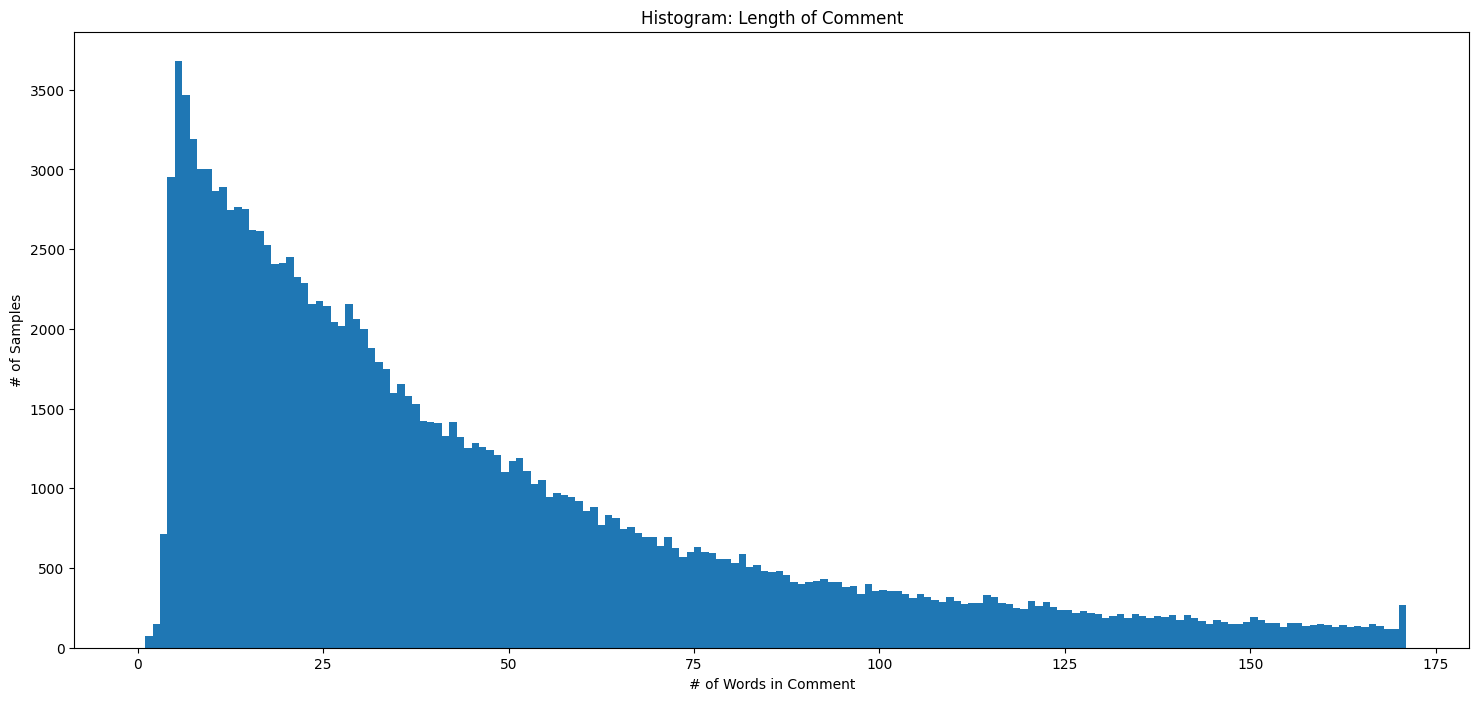

The maximum length of Speeches is 1411 words.


In [5]:
data['text_length'] = data['text'].str.split().str.len()

n_bin=170
data.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin + 1), bins=(n_bin + 1))
plt.title('Histogram: Length of Comment')
plt.xlabel('# of Words in Comment')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Speeches is {max(data['text_length'])} words.")

#### Visual: Tweet Length by Class

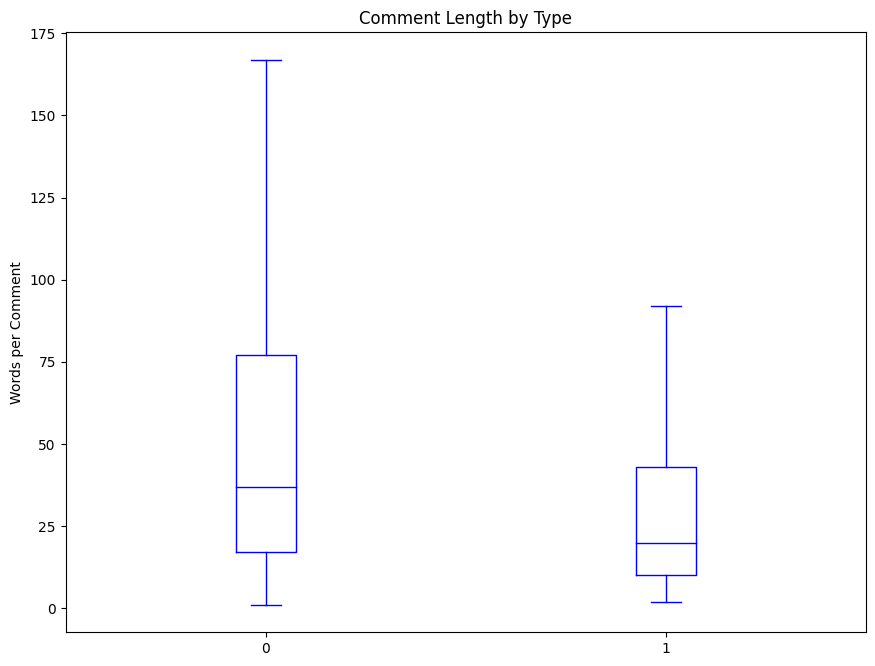

In [6]:
data.boxplot("text_length", by="label", grid=False, showfliers=False, color="Blue", figsize=(10,8))

plt.suptitle('')
plt.title('Comment Length by Type')
plt.xlabel('')
plt.ylabel('Words per Comment')
plt.show()

#### Final Data Preprocessing

In [7]:
data = data[data['text_length'] < 171]

data = data.drop(columns=["text_length"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146214 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    146214 non-null  object
 1   label   146214 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


#### Number of Samples in Each Class

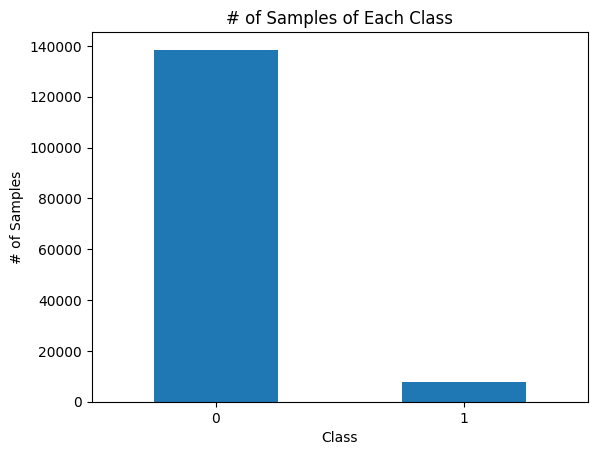

In [8]:
class_counts = data['label'].value_counts()

class_counts.plot.bar()
plt.suptitle('')
plt.title('# of Samples of Each Class')
plt.xlabel('Class')
plt.ylabel('# of Samples')
plt.xticks(rotation = 0)
plt.legend('', frameon=False)
plt.show()

#### Convert DataFrame to Dataset

In [9]:
dataset = Dataset.from_pandas(data)

dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 146214
})

#### Split Dataset into Training Evaluation Datasets

In [10]:
train_eval = dataset.train_test_split(train_size=0.80)

ds = DatasetDict({
    'train' : train_eval['train'],
    'eval' : train_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

Training Dataset Shape: (116971, 3)
Evaluation Dataset Shape: (29243, 3)


#### Basic Values/Constants

In [11]:
set_seed = 42
NUM_OF_EPOCHS = 1

BATCH_SIZE = 64
LEARNING_RATE = 2e-5

MAX_LENGTH = 220
MODEL_CKPT = "kssteven/ibert-roberta-base"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Abusive_Or_Threatening_Speech"

DEVICE = torch.device("cpu")

STRATEGY = "epoch"
REPORTS_TO = "tensorboard"

print(f"This project will utilize the {str(DEVICE).upper()} to train and evaluate.")
print(f"This project will have a maximum length for the input text of {MAX_LENGTH} tokens.")
print(f"The model checkpoint used for this project is: {MODEL_CKPT}")

This project will utilize the CPU to train and evaluate.
This project will have a maximum length for the input text of 220 tokens.
The model checkpoint used for this project is: kssteven/ibert-roberta-base


#### Tokenize Entire Dataset

In [12]:
# Define Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# Tokenize Method
def tokenize(batch):
    return tokenizer(batch['text'], 
                     padding=True, 
                     truncation=True, 
                     max_length=MAX_LENGTH, 
                     return_tensors="pt")

# Tokenize entire dataset
encoded_data = ds.map(tokenize, batched=True, batch_size=None)

print('Training data shape:', encoded_data['train'].shape)
print('Validation data shape:', encoded_data['eval'].shape)

print(encoded_data['train'].features)
print(encoded_data['train'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Training data shape: (116971, 5)
Validation data shape: (29243, 5)
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 116971
})


#### Instantiate Model

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_OF_LABELS,
    id2label=id2label,
    label2id=label2id
    ).to(DEVICE)

Some weights of the model checkpoint at kssteven/ibert-roberta-base were not used when initializing IBertForSequenceClassification: ['lm_head.layer_norm.weight', 'ibert.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'ibert.pooler.dense.weight']
- This IS expected if you are initializing IBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing IBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of IBertForSequenceClassification were not initialized from the model checkpoint at kssteven/ibert-roberta-base and are newly initialized: ['ibert.encoder.laye

#### Define Function to Compute Metrics

In [14]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                       references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                       references=p.label_ids)["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                   references=p.label_ids)["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), 
                                         references=p.label_ids)["precision"]
    
    return {"accuracy" : accuracy, 
            "F1" : f1_score,
            "Recall" : recall,
            "Precision" : precision,
            }

#### Define TrainingArguments

In [15]:
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE, 
    weight_decay=0.01,
    report_to=REPORTS_TO,
    log_level="error",
    logging_strategy='steps', 
    logging_steps=50,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_first_step=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_F1",
    greater_is_better=True,
    disable_tqdm=False,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Data Collator

In [16]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)

#### Subclass Trainer to Handle Class Imbalance

In [17]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [18]:
trainer = CustomTrainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'], 
                  eval_dataset=encoded_data['eval'], 
                  data_collator=data_collator,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/ibert-roberta-base-Abusive_Or_Threatening_Speech into local empty directory.


#### Train Model

In [19]:
train_results = trainer.train()

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1828 [00:00<?, ?it/s]

{'loss': 0.7234, 'learning_rate': 1.9989059080962803e-05, 'epoch': 0.0}
{'loss': 0.3222, 'learning_rate': 1.9452954048140046e-05, 'epoch': 0.03}
{'loss': 0.132, 'learning_rate': 1.890590809628009e-05, 'epoch': 0.05}
{'loss': 0.1327, 'learning_rate': 1.8358862144420135e-05, 'epoch': 0.08}
{'loss': 0.1067, 'learning_rate': 1.7811816192560176e-05, 'epoch': 0.11}
{'loss': 0.1085, 'learning_rate': 1.726477024070022e-05, 'epoch': 0.14}
{'loss': 0.0917, 'learning_rate': 1.6717724288840264e-05, 'epoch': 0.16}
{'loss': 0.1098, 'learning_rate': 1.617067833698031e-05, 'epoch': 0.19}
{'loss': 0.1011, 'learning_rate': 1.562363238512035e-05, 'epoch': 0.22}
{'loss': 0.0979, 'learning_rate': 1.5076586433260396e-05, 'epoch': 0.25}
{'loss': 0.1076, 'learning_rate': 1.452954048140044e-05, 'epoch': 0.27}
{'loss': 0.1102, 'learning_rate': 1.3982494529540483e-05, 'epoch': 0.3}
{'loss': 0.0987, 'learning_rate': 1.3435448577680525e-05, 'epoch': 0.33}
{'loss': 0.0958, 'learning_rate': 1.2888402625820571e-05, '

  0%|          | 0/457 [00:00<?, ?it/s]

{'eval_loss': 0.08016789704561234, 'eval_accuracy': 0.9741476592688849, 'eval_F1': 0.7772539776075428, 'eval_Recall': 0.8609660574412533, 'eval_Precision': 0.7083780880773362, 'eval_runtime': 13441.5223, 'eval_samples_per_second': 2.176, 'eval_steps_per_second': 0.034, 'epoch': 1.0}
{'train_runtime': 331532.8168, 'train_samples_per_second': 0.353, 'train_steps_per_second': 0.006, 'train_loss': 0.10460054101646599, 'epoch': 1.0}


#### Save Model & Metrics on Training Dataset

In [20]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/949M [00:00<?, ?B/s]

Upload file runs/May05_15-41-09_Lees-Air/events.out.tfevents.1683319277.Lees-Air.57344.0:   0%|          | 1.0…

To https://huggingface.co/DunnBC22/ibert-roberta-base-Abusive_Or_Threatening_Speech
   9d0356a..2c198db  main -> main

To https://huggingface.co/DunnBC22/ibert-roberta-base-Abusive_Or_Threatening_Speech
   2c198db..c1cbd37  main -> main



***** train metrics *****
  epoch                    =                 1.0
  train_loss               =              0.1046
  train_runtime            = 3 days, 20:05:32.81
  train_samples_per_second =               0.353
  train_steps_per_second   =               0.006


#### Push Model to HuggingFace Hub

In [21]:
trainer.push_to_hub(commit_message="All Dunn!!!")

To https://huggingface.co/DunnBC22/ibert-roberta-base-Abusive_Or_Threatening_Speech
   c1cbd37..987e7dd  main -> main



'https://huggingface.co/DunnBC22/ibert-roberta-base-Abusive_Or_Threatening_Speech/commit/987e7ddf3b7455cce3513272f2ad1fc7fab3db5a'

#### Evaluate Model

In [22]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

  0%|          | 0/457 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        1.0
  eval_F1                 =     0.7773
  eval_Precision          =     0.7084
  eval_Recall             =      0.861
  eval_accuracy           =     0.9741
  eval_loss               =     0.0802
  eval_runtime            = 3:40:13.33
  eval_samples_per_second =      2.213
  eval_steps_per_second   =      0.035


### Notes & Other Takeaways From This Project
****
- These text inputs are slightly different than the inputs from other projects that I have trained. The inputs are not spam and the intent is not to measure sentiment, but rather this project seeks to find any reviews that need to be flagged, reviewed and potentially removed. 
****

### Citations
- Model Checkpoint
    > @article{kim2021bert, title={I-BERT: Integer-only BERT Quantization}, author={Kim, Sehoon and Gholami, Amir and Yao, Zhewei and Mahoney, Michael W and Keutzer, Kurt}, journal={arXiv preprint arXiv:2101.01321}, year={2021}}

